**Problem Statement**

Predict the orientation of whales using annotated dolphin image set. The annotations contain bounding box coordinates and angle in radians as theta.  

The give dataset is in test,train, validation sets with annotations

Following are preformed for analysis and solution 


*   EDA  - The images from train set are visualized with bounding box . Basic EDA is performed on dataset to understand the dataset. 

* Preprocessing - The train, test and validation sets data, image location, annotation details needed for model is saved as a dataframe, that is further used by the model dataset. The orientation angle is converted to degrees and used as prediction output and fares better with regression loss. 

*   Model and Dataset - For each item of dataset, the image is read from the filename with prefix and resize, normalize transform is applied to suit the resnet model input. 
Pretrained Resnet34 model is used as a base and FC layer is added for theta output. Mean of abosolute values of prediction and atual theta values are used for regression loss. 
* Training - The model is trained for 15 to 30 epochs. However training for more number of epochs could yield better results. Theta angle in radians is used as output feature for training the model. 

* Test Results - The test set is used for predictions on the trained model and the results are shown as a dataframe and saved as a csv file

* Experiments - MSE loss, L1 Loss and absolute mean loss are tried and absolute mean loss seems to have better performance


* Further Enhancements - Model can be tried for larger number of epcohs on CUDA instance. The current model is trained on Google colab for 15-30 epochs


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/wm'

/content/drive/MyDrive/wm


**Datasets** : get the datasets and save in the drive

In [ ]:

#!wget https://cthulhu.dyn.wildme.io/public/data/orientation_test_whaleshark.zip
#!unzip orientation_test_whaleshark.zip
#!wget https://cthulhu.dyn.wildme.io/public/data/orientation_test_spotted_dolphin.zip
#!unzip orientation_test_spotted_dolphin.zip

In [3]:
import json
import numpy as np
from operator import itemgetter
import pandas as pd

import os
from glob import glob
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np
import albumentations as A
import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
%reload_ext autoreload
%autoreload 2
%matplotlib inline


**Preprocessing** 

Read the annotations from json file to a dataframe. Create a thetadeg column that holds the orientation angle in degrees

In [4]:

def get_key_from_value(img_id_list, val):
    
    k = np.where(img_id_list==val)
    idx = k[0][0]
    return idx
    

def get_annot_df(jsonfile)  :

  with open(jsonfile) as json_file:
    data = json.load(json_file)
 
    # Print the type of data variable
    images = data['images']
    annotations = data['annotations']

    image_id_list = np.asarray(list(map(itemgetter('id'), images)))
    #print(image_id_list[:10])
    image_file_list = list(map(itemgetter('file_name'), images))
    image_ht_list = list(map(itemgetter('height'), images))
    image_wd_list = list(map(itemgetter('width'), images))
    anno_list=[]
    for annot in annotations:
      a_img_id = annot['image_id']
      idx = get_key_from_value(image_id_list,  a_img_id)
    
      img_f, img_wd, img_ht = image_file_list[idx], image_wd_list[idx], image_ht_list[idx]
      anno = {}
      anno['img_id'] = a_img_id
  
      anno['file_name'] =img_f
      anno['width'] =img_wd
      anno['height'] =img_ht
      anno['bbox'] = annot['bbox']
      anno['theta'] = annot['theta']
      anno['thetadeg'] = math.degrees( anno['theta'] )
      anno['class']  = annot['category_id']
      anno_list.append(anno)
  return pd.DataFrame(anno_list)


Obtain train, test , validation features into respective dataframes 

In [5]:
DS = 'orspotteddolphincoco/'
tr_jsonfile = DS+'annotations/instances_train2020.json'
train_df = get_annot_df(tr_jsonfile)


In [6]:
train_df.head()

,img_id,file_name,width,height,bbox,theta,thetadeg,class
0,1,000000000001.jpg,2400,1800,"[0, 72, 2399, 1727]",4.430205,253.832031,0
1,4,000000000004.jpg,2400,1600,"[57, 327, 2342, 914]",4.804537,275.279665,0
2,5,000000000005.jpg,2400,1800,"[353, 598, 926, 644]",7.585943,434.642507,0
3,6,000000000006.jpg,2400,1800,"[535, 399, 884, 1017]",1.982408,113.583590,0
4,7,000000000007.jpg,2400,1800,"[0, 0, 2399, 1799]",-0.978041,-56.037616,0


In [7]:
DS = 'orspotteddolphincoco/'
ts_jsonfile = DS+'annotations/instances_test2020.json'
test_df = get_annot_df(ts_jsonfile)



In [8]:
DS = 'orspotteddolphincoco/'
val_jsonfile = DS+'annotations/instances_val2020.json'
val_df = get_annot_df(val_jsonfile)


In [9]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)



In [17]:
#Function to visualize the annotations
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    print(bbox, len(bbox))
    [x_min, y_min, w, h] = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bbox):
    img = image.copy()
    img = visualize_bbox(img, bbox, 'shark')
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)

orspotteddolphincoco//images/train2020/000000000001.jpg 2400 1800 [0, 72, 2399, 1727]
[0, 72, 2399, 1727] 4


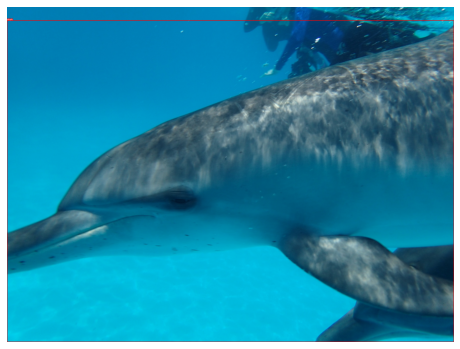

In [18]:
#Visualize a sample train image with bounding box annotation
PFX = DS+'/images/train2020/'
idx=0

file = PFX+train_df['file_name'][idx]
wd = train_df['width'][idx]
ht = train_df['height'][idx]
bbox =train_df['bbox'][idx]
print(file, wd, ht, bbox)
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image, bbox)

In [19]:
# Apply resize transform to image (224x224) and see the bounding box params
labels = ['shark']
rsztransform = A.Compose(
    [A.Resize(224,224, p=1)],
    bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
   )

idx=1
PFX = DS+'images/train2020/'
file = PFX+train_df['file_name'][idx]
wd = train_df['width'][idx]
ht = train_df['height'][idx]
bbox =train_df['bbox'][idx]
print(file, wd, ht, bbox)
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape, bbox, labels)
transformed = rsztransform(image=image, bboxes=[bbox], labels=labels)
f = transformed['image']


tbox = transformed['bboxes'][0]

print(f.shape, transformed['bboxes'][0])

orspotteddolphincoco/images/train2020/000000000004.jpg 2400 1600 [57, 327, 2342, 914]
(1600, 2400, 3) [57, 327, 2342, 914] ['shark']
(224, 224, 3) (5.32, 45.78, 218.58666666666667, 127.96000000000001)


SharkDataset Class with transform using the dataframe with transform and normalize function

In [10]:


def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]
def check_bbox(bbox1, sz):
      #Check if bbox boundaries are in range W, H 
       
      bbox=bbox1
      
      if bbox[0] >sz[0]:
        bbox[0] = sz[0]
      if bbox[2] >sz[0]:
        bbox[2] = sz[0]          
      if bbox[1] >sz[1]:
        bbox[1] = sz[1]
      if bbox[3] >sz[1]:
        bbox[3] = sz[1]
      
      return(bbox)

class SharkDataset(Dataset):
    def __init__(self, pfx, paths, bb, y, theta):
        self.pfx = pfx
        self.paths = paths.values
        self.bb = bb.values
        self.theta = theta.values
        self.y = y.values
        self.category_ids = [0]
        self.transforms = A.Compose(
                          [A.Resize(224,224, p=1)],
                          bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'])
)
        
    def __len__(self):
        return len(self.paths)

    
    
    def __getitem__(self, idx):
        path = self.pfx+self.paths[idx]
        y_class = self.y[idx]
        y_bb1=self.bb[idx]
        if(path==''):
          print(path, idx)
        x=''
        try:
          x = cv2.imread(str(path)).astype(np.float32)
        except:
          print('image read error', idx, path )
          
        image = cv2.cvtColor(x,  cv2.COLOR_BGR2RGB)/255
        sz = image.shape
        
        y_bb = check_bbox(y_bb1, list(sz))
        
        try:
          tr_x = self.transforms(image=image, bboxes=[y_bb], category_ids=self.category_ids)
        except:
          print('invalid transforms error', sz, y_bb1, y_bb )
        x = tr_x['image']
        
        x = normalize(x)
        x = np.rollaxis(x, 2)
         
        y_theta = self.theta[idx].astype('float')
        
        
        return x, y_class, y_bb, y_theta

In [11]:
#Function that returns of indices of rows with negative bounding box parameters
def get_neg_idx(df):
  nitem = ''
  idx_nitems=[]

  for  i in  df.index.values.tolist():
    for n in df['bbox'][i]:
     if n < 0:
       nitem = n
       idx_nitems.append(i)
  return(idx_nitems)



In [12]:
nidx = get_neg_idx(train_df)
print(nidx)
if(nidx!= -1):
  print(train_df['bbox'][nidx])
  train_df.drop(nidx, inplace=True)

[520]
520    [1081, 1826, 401, -27]
Name: bbox, dtype: object


In [13]:
nidx = get_neg_idx(val_df)
print(nidx)
if(nidx!= -1):
  print(val_df['bbox'][nidx])
  val_df.drop(nidx, inplace=True)

[]
Series([], Name: bbox, dtype: object)


In [ ]:
nidx = get_neg_idx(test_df)
print(nidx)
print(test_df.iloc[nidx])
print(len(test_df))

test_df = test_df[~test_df.index.isin(nidx)]
print(len(test_df))

In [27]:
print(len(train_df['file_name']),len(train_df['bbox']), len(train_df['theta']) )


2633 2633 2633


The model is trained on theta in radians as loss is better converged for the dolhpin dataset

In [15]:
TR_PFX= DS+'images/train2020/'
X_train = train_df
train_ds = SharkDataset(TR_PFX, X_train['file_name'],X_train['bbox'] ,X_train['class'],X_train['theta'] )
#train_ds = SharkDataset(TR_PFX, X_train['file_name'],X_train['bbox'] ,X_train['class'],X_train['thetadeg'] )
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)


In [16]:
VAL_PFX= DS+'images/val2020/'
X_val = val_df
valid_ds = SharkDataset(VAL_PFX, X_val['file_name'],X_val['bbox'] ,X_val['class'],X_val['theta'] )


In [17]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,num_workers=2)

Define model with Resnet34 pretrained model, add FC layer for orientation output 

In [18]:
class SharkO_model(nn.Module):
    def __init__(self):
        super(SharkO_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.theta = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        #return self.theta(x), self.bb(x)
        return self.theta(x)

In [19]:
##Training 

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [20]:
#Training loop function
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb, y_theta in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            
            y_bb = torch.cat(y_bb, dim=0)
            y_bb = y_bb.cuda()
            y_theta = y_theta.type(torch.FloatTensor) \
                  .reshape((y_theta.shape[0], 1))
            y_theta = y_theta.cuda()
            out_theta = model(x)
            loss_theta = F.l1_loss(out_theta, y_theta, reduction="mean")
            loss = loss_theta*C
            #loss_theta = F.mse_loss(out_theta,y_theta)
            #loss=torch.abs(out_theta - y_theta).mean() *C
            #loss = loss_theta.sum()
            
            model.zero_grad()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f " % (train_loss, val_loss))
    return sum_loss/total

In [21]:
#Validation metrics
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb, y_theta in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = torch.cat(y_bb, dim=0)
    
        y_theta = y_theta.type(torch.FloatTensor) \
                  .reshape((y_theta.shape[0], 1))
        y_theta = y_theta.cuda()
        out_theta= model(x)
        loss_theta = F.l1_loss(out_theta, y_theta, reduction="mean")
        #loss_theta = F.mse_loss(out_theta,y_theta)
        #loss_theta = loss_theta.sum()
        #loss_theta=torch.abs(out_theta - y_theta).log()
        #loss_theta=torch.abs(out_theta - y_theta).mean()             
        loss = loss_theta*C
        sum_loss += loss.item()
        total += batch
    return sum_loss/total

In [25]:
model = SharkO_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=1e-3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15, C=10)

train_loss 0.526 val_loss 0.488 
train_loss 0.448 val_loss 0.555 
train_loss 0.376 val_loss 0.519 
train_loss 0.353 val_loss 0.396 
train_loss 0.320 val_loss 0.355 
train_loss 0.298 val_loss 0.305 
train_loss 0.290 val_loss 0.328 
train_loss 0.282 val_loss 0.285 
train_loss 0.279 val_loss 0.315 
train_loss 0.280 val_loss 0.298 


In [ ]:

torch.save(model.state_dict(), 'dlph_obb.pth')

In [27]:
model.load_state_dict(torch.load('dlph_obb.pth'))

<All keys matched successfully>

In [ ]:
#parameters = filter(lambda p: p.requires_grad, model.parameters())
#optimizer = torch.optim.Adam(parameters, lr=1e-3)
update_optimizer(optimizer, 1e-3)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=30)

In [ ]:
torch.save(model.state_dict(), 'dlph_obb1.pth')

**Model Evaluation and Predictions on Test Set**

In [28]:
#Drop rows with negative values of bounding box elements
DS = 'orspotteddolphincoco/'
ts_jsonfile = DS+'annotations/instances_test2020.json'
test_df = get_annot_df(ts_jsonfile)

nidx = get_neg_idx(test_df)
test_df = test_df[~test_df.index.isin(nidx)]
test_df.reset_index(inplace = True, drop = True)



In [29]:
# Some of the image files are in gzip format, convert them to jpg format
TS_PFX=DS+'images/test2020/'

gzfiles = glob(TS_PFX+'*.gz')
for f in gzfiles:
  !gunzip {f}


In [31]:
TEST_PFX= DS+'images/test2020/'
X_val = test_df
test_ds = SharkDataset(TEST_PFX, X_val['file_name'],X_val['bbox'] ,X_val['class'],X_val['theta'] )
test_dl = DataLoader(test_ds, batch_size=batch_size,num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [32]:

model.eval()
pred=[]
for x, y_class, y_bb, y_theta in test_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        
        y_theta = y_theta.type(torch.FloatTensor) \
                  .reshape((y_theta.shape[0], 1))
        y_theta = y_theta.cuda()
        out_theta= model(x)
        pred_thetas = out_theta.detach().cpu().numpy() 
        for elem in pred_thetas:
            pred.append(elem)
        

In [33]:
len(pred)
preds = np.concatenate( pred, axis=0 )

In [34]:

test_df['preds']= preds

In [ ]:
test_df.tail(20)

In [ ]:
#Save the predictions
test_df.to_csv('pred_dolphn.csv', index=False)

**Observations**

The Dolphin dataset model is based on pretrained Resnet34 model and modified with FC layer for theta predictions. 

*   Theta angle in radians is used for this dataset as predicted feature. 
*  L1 loss  seemed to fare better compared to MSE loss.
*   Model is trained on Google Colab for fewer epochs. 
*   Model can be further enhanced on GPU with higher RAM VM instance 
*  The predictions for negative angles seem to be problem. 




